# Titanic Disaster Survival Predicrtion

## Importing Required Libraries
Here, we import essential Python libraries for data manipulation, visualization, and machine learning.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
#  Other libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

#### Reading files for training and testing 

## Loading the Dataset
We load the Titanic dataset to begin exploratory data analysis (EDA) and preprocessing.

In [2]:
train = pd.read_csv(r"D:\Projects\data\train.csv")
test = pd.read_csv(r"D:\Projects\data\test.csv")

In [3]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Handling Missing Data & Removing Duplicates
We address missing values in the dataset to ensure model performance is not negatively impacted.

In [4]:
print(f'Train Size : {train.shape}', f'Test Size : {test.shape}',sep='\n')

Train Size : (891, 12)
Test Size : (418, 11)


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


#### Mergining both set on indicators so to do cleaning easily and efficintly and later to split them back

In [6]:
train['dataset'] = 'train'
test['dataset'] = 'test'
df = pd.concat([train,test],axis=0)

#### Checking Duplicates values

In [7]:
df.duplicated().sum()

np.int64(0)

#### Chechking null values and datatypes 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  dataset      1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 143.2+ KB


#### As Cabin column has only 295 non-null values out of 1309 so it does not represent the population so dropping would be best  

In [9]:
df.drop(['Cabin'],axis=1,inplace=True)

#### Filling the Embarked column which represnts 3 harbors where from peple have entered with mode

In [10]:
df.Embarked.value_counts()

Embarked
S    914
C    270
Q    123
Name: count, dtype: int64

In [11]:
df.Embarked.value_counts()
df.Embarked = df.Embarked.fillna('S')

#### Fare column has one missing value so can be filled with median of its column if it has been a lot then better approach was to fill it by grouping by the class then fill that particular row by median of that class  

In [12]:
df.Fare = df.Fare.fillna(df.Fare.median())

## Feature Engineering
We create new features (such as extracting titles from names) and later after EDA transform categorical variables into numerical representations.

In [13]:
df['title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [14]:
df.title.value_counts()

title
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Major         2
Mlle          2
Ms            2
Mme           1
Don           1
Sir           1
Lady          1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: count, dtype: int64

Too many categories reducing by mapping the rarely occured to others  

In [15]:
title_mapping = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Mme': 'Mrs',      # Mme = Mrs (French)
    'Mlle': 'Miss',    # Mlle = Miss (French)
    'Ms': 'Miss',
    
    'Dr': 'Other',
    'Rev': 'Other',
    'Col': 'Other',
    'Major': 'Other',
    'Don': 'Other',
    'Sir': 'Other',
    'Lady': 'Other',
    'Capt': 'Other',
    'Countess': 'Other',
    'Jonkheer': 'Other',
    'Dona': 'Other'
}

df['title'] = df['title'].map(title_mapping)

print(df['title'].value_counts())


title
Mr        757
Miss      264
Mrs       198
Master     61
Other      29
Name: count, dtype: int64


#### Fill missing ages with median age of each title group


In [16]:
df['Age'] = df.groupby('title')['Age'].transform(lambda x: x.fillna(x.median()))

#### Combining two features to make a one powerfull 

In [17]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df.drop(['SibSp','Parch'],axis=1,inplace=True)


## Exploratory Data Analysis (EDA)
We analyze the dataset to identify missing values, distributions, and potential relationships between features and survival.

In [18]:
df.describe()

,PassengerId,Survived,Pclass,Age,Fare,FamilySize
count,1309.000000,891.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.416478,33.281086,1.883881
std,378.020061,0.486592,0.837836,13.159100,51.741500,1.583639
min,1.000000,0.000000,1.000000,0.170000,0.000000,1.000000
25%,328.000000,0.000000,2.000000,22.000000,7.895800,1.000000
50%,655.000000,0.000000,3.000000,29.000000,14.454200,1.000000
75%,982.000000,1.000000,3.000000,35.000000,31.275000,2.000000
max,1309.000000,1.000000,3.000000,80.000000,512.329200,11.000000


#### From above description the average person pays 33$ and there is max 512 thats a lot let's visualize to spot the outliers

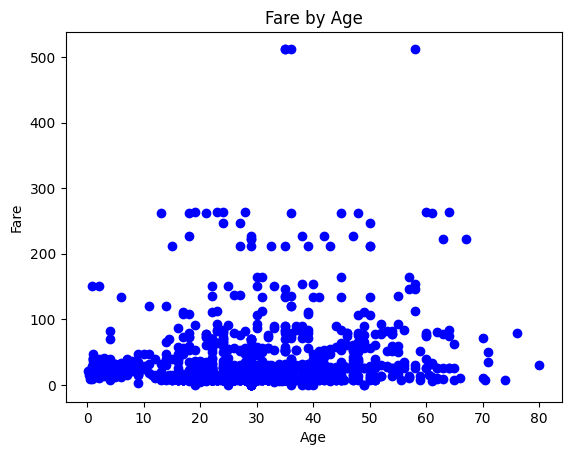

In [19]:
plt.title('Fare by Age')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.scatter(df['Age'],df['Fare'],color='Blue')

#### Let's visualize again after removing the outliers by Zscore

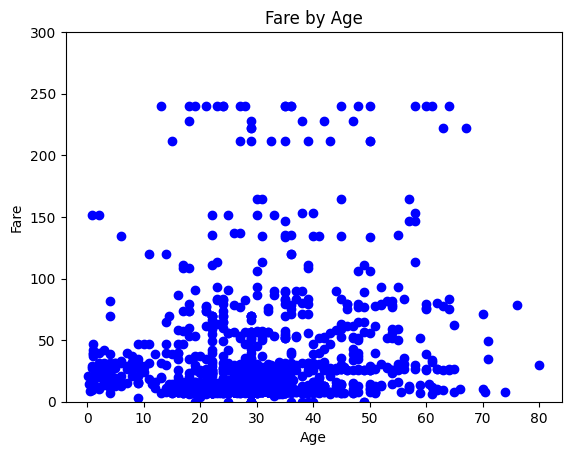

In [20]:
mean = df['Fare'].mean()
std = df['Fare'].std()

threshold = 4
upper_bound = mean + threshold * std
lower_bound = mean - threshold * std

df['Fare'] = df['Fare'].clip(lower=0, upper=upper_bound)

plt.title('Fare by Age')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.ylim(0, 300)
plt.scatter(df['Age'],df['Fare'],color='Blue')

#### Examining the distributions by titles 

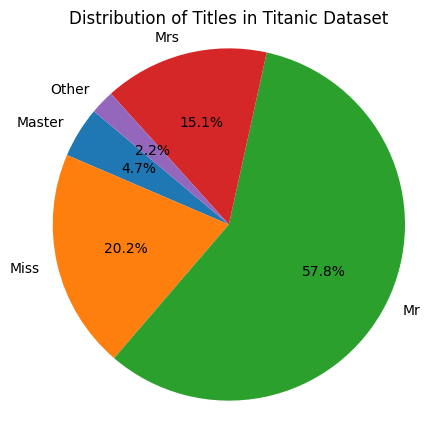

In [21]:
title_counts = df.groupby('title')['PassengerId'].count()

plt.figure(figsize=(5, 5))
plt.pie(title_counts, labels=title_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Titles in Titanic Dataset')
plt.axis('equal')  
plt.show()


How much impact do title has on survival ?

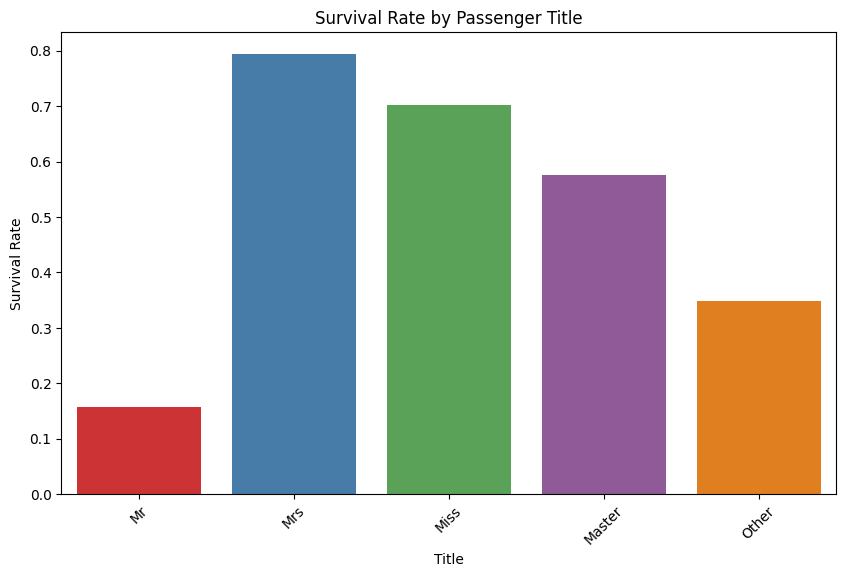

In [22]:
train = df[df.dataset == 'train']

plt.figure(figsize=(10,6))
sns.barplot(data=train, x="title", y="Survived", errorbar=None, palette="Set1")

plt.title("Survival Rate by Passenger Title")
plt.ylabel("Survival Rate")
plt.xlabel("Title")
plt.xticks(rotation=45)
plt.show()


We have created title feature to handle the missing values efficiently and add extra feature to ML. Imagine a boy whos title is master and filled the median average of whole dataset which is 29. A boy 29 years old?. 

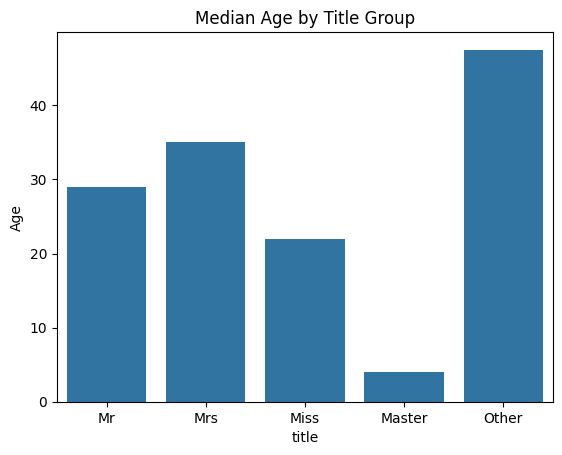

In [23]:
df = df.reset_index(drop=True)
sns.barplot(x='title', y='Age', data=df, estimator=np.median, errorbar=None)

plt.title("Median Age by Title Group")
plt.show()


Checking How skewed is dataset 

In [24]:

for col in df.select_dtypes(include=['int64','float64']):
    print(f"{col}: {skew(df[col].dropna()):.2f}")


PassengerId: 0.00
Survived: 0.48
Pclass: -0.60
Age: 0.48
Fare: 2.99
FamilySize: 2.85


Lets visualize how much most skewed column is 

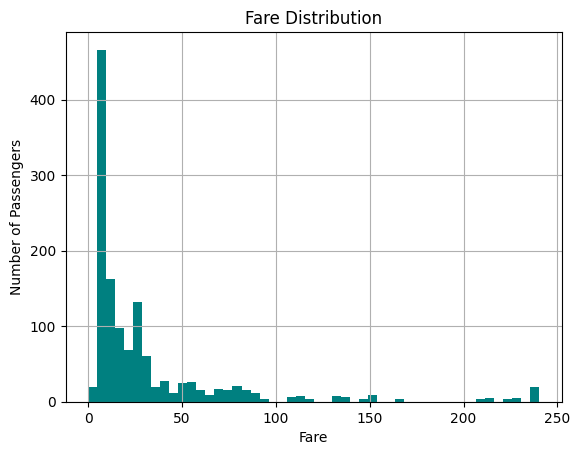

In [25]:
df['Fare'].hist(bins=50, color="teal")  
plt.title("Fare Distribution")
plt.xlabel("Fare")       
plt.ylabel("Number of Passengers")  
plt.show()


Lets see how much age impact on survival 

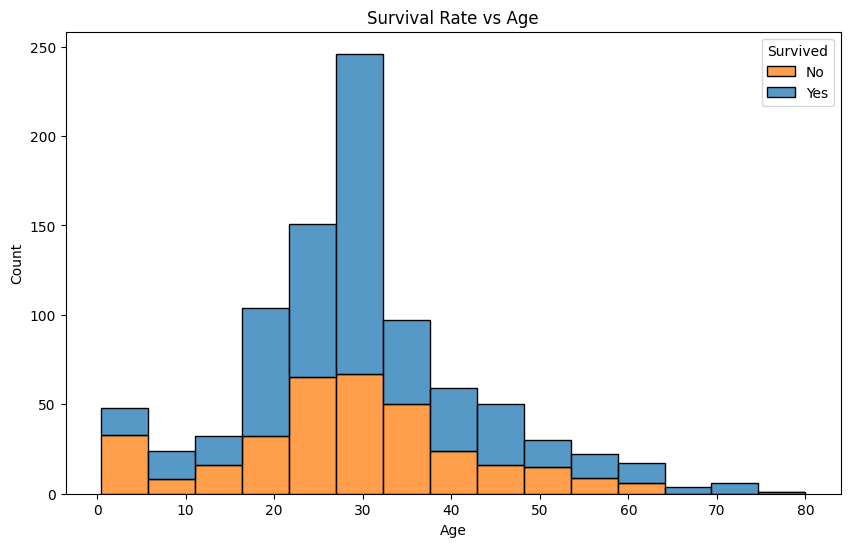

In [26]:
plt.figure(figsize=(10,6))
sns.histplot(data=train, x="Age", hue="Survived", multiple="stack", bins=15)
plt.title("Survival Rate vs Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.show()


Kids and people with age between 32 to 38 have more survive ratio

And What about gender? let's see

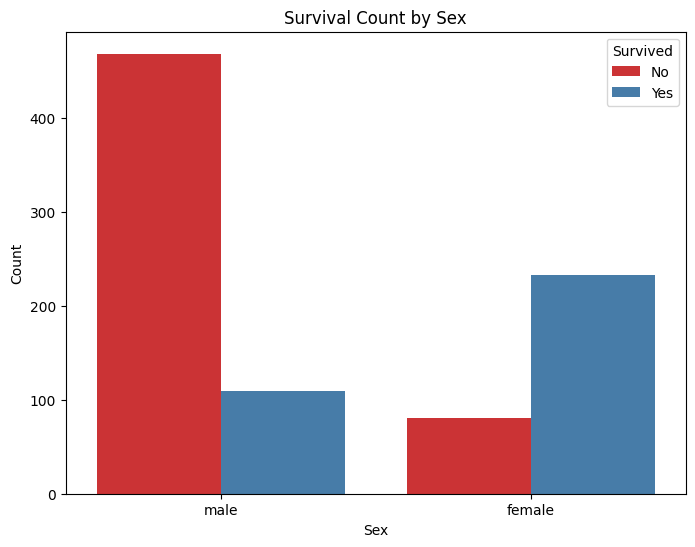

In [27]:
plt.figure(figsize=(8,6))

sns.countplot(data=train, x="Sex", hue="Survived", palette="Set1")

plt.title("Survival Count by Sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.show()

Clearly, Women have more survived then compared to men

Now Family 

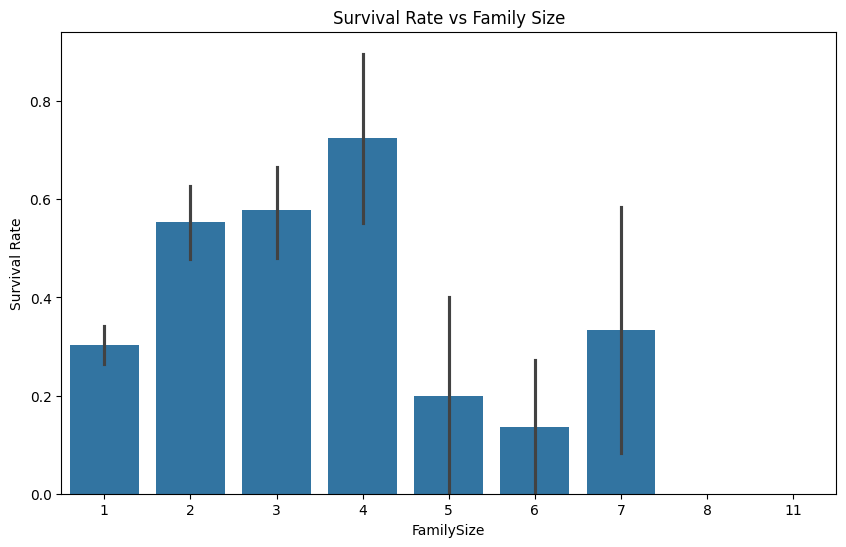

In [28]:
plt.figure(figsize=(10,6))
sns.barplot(data=train, x="FamilySize", y="Survived", estimator=lambda x: sum(x)/len(x))
plt.title("Survival Rate vs Family Size")
plt.ylabel("Survival Rate")
plt.show()

An ideal family of 4 has survival rate higher then 3 and 2 

And The last The Harbour 

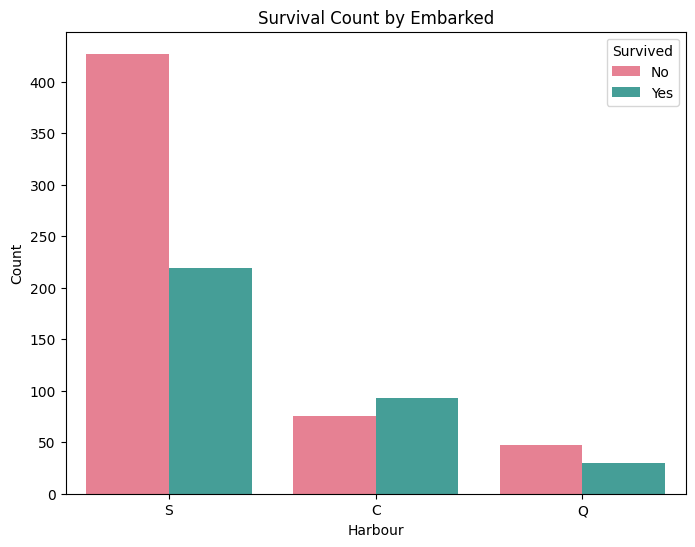

In [29]:
plt.figure(figsize=(8,6))

sns.countplot(data=train, x="Embarked", hue="Survived", palette='husl')

plt.title("Survival Count by Embarked")
plt.xlabel("Harbour")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.show()

The passenger from C have survived more then others

## Encoding Categorical Variables
We use one-hot encoding to transform categorical variables such as `Sex`, `Embarked`, and `Title` into numerical form.

In [30]:
df = pd.get_dummies(df, columns=["Sex", "Embarked", "title"], drop_first=True)
df.head()

df.head()

,PassengerId,Survived,Pclass,Name,Age,Ticket,Fare,dataset,FamilySize,Sex_male,Embarked_Q,Embarked_S,title_Miss,title_Mr,title_Mrs,title_Other
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,A/5 21171,7.2500,train,2,True,False,True,False,True,False,False
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,PC 17599,71.2833,train,2,False,False,False,False,False,True,False
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,STON/O2. 3101282,7.9250,train,1,False,False,True,True,False,False,False
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,113803,53.1000,train,2,False,False,True,False,False,True,False
4,5,0.0,3,"Allen, Mr. William Henry",35.0,373450,8.0500,train,1,True,False,True,False,True,False,False


## Splitting the Dataset
We split the dataset into training and testing sets to evaluate model performance fairly.

In [31]:
df.drop(['Name','Ticket'],axis=1,inplace=True)
train = df[df.dataset == 'train'].drop(columns=['dataset','PassengerId'])
test = df[df.dataset == 'test'].drop(columns=['dataset','Survived'])


Saving passengerId in ids so later can do the submission of test data prediction

In [32]:
ids = test['PassengerId']
test.drop(['PassengerId'], axis=1, inplace=True)

How every column is correlated with each other 

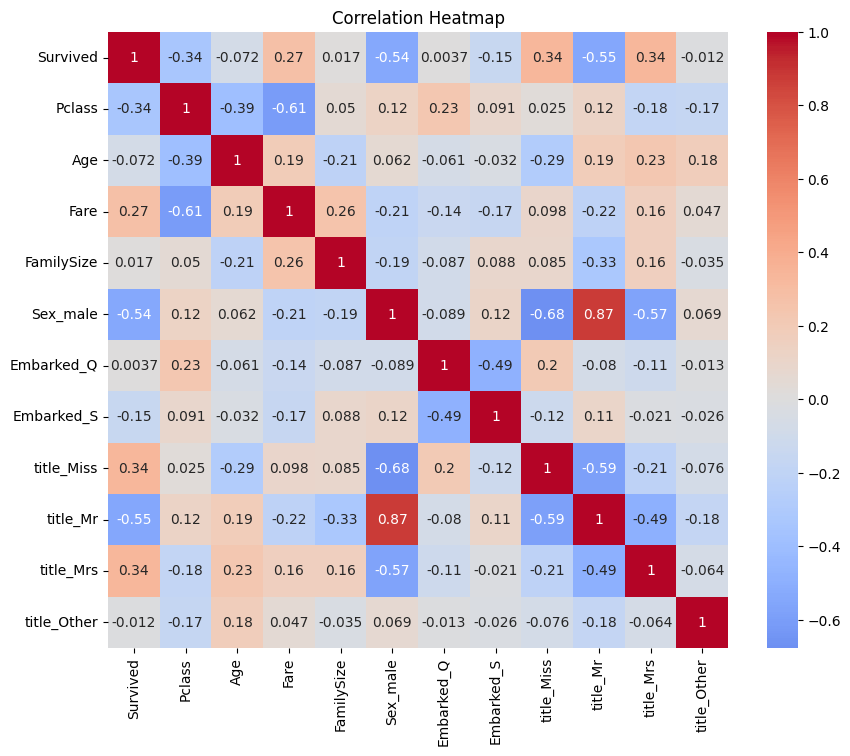

In [33]:
df.drop(['PassengerId'],axis=1,inplace=True)
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


Spliting the train dataset so we evalute the performance

In [34]:
Y = train['Survived']
x_train, x_test, y_train, y_test = train_test_split(train.drop(['Survived'],axis=1), Y ,test_size=0.2,random_state=42)
len(x_train)

712

## Defining Model Parameters
We define hyperparameter grids for multiple machine learning models including Logistic Regression, Decision Tree, Random Forest, Naive Bayes, SVM, KNN, and XGBoost.

In [35]:
train

,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S,title_Miss,title_Mr,title_Mrs,title_Other
0,0.0,3,22.0,7.2500,2,True,False,True,False,True,False,False
1,1.0,1,38.0,71.2833,2,False,False,False,False,False,True,False
2,1.0,3,26.0,7.9250,1,False,False,True,True,False,False,False
3,1.0,1,35.0,53.1000,2,False,False,True,False,False,True,False
4,0.0,3,35.0,8.0500,1,True,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,2,27.0,13.0000,1,True,False,True,False,False,False,True
887,1.0,1,19.0,30.0000,1,False,False,True,True,False,False,False
888,0.0,3,22.0,23.4500,4,False,False,True,True,False,False,False
889,1.0,1,26.0,30.0000,1,True,False,False,False,True,False,False


In [36]:
model_prams = {
    'Logistic Regression': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(max_iter=500))
        ]),
        'prams': {
            'clf__C': [0.01, 1, 10, 100],
        }
    },

    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'prams': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [None, 5, 20, 50],
            'max_features': [None, 'sqrt', 'log2']
        }
    },

    'Random Forest': {
        'model': RandomForestClassifier(),
        'prams': {
            'n_estimators': [50, 100, 200],
            'criterion': ['gini', 'entropy', 'log_loss']
        }
    },

    'GaussianNB': {
        'model': GaussianNB(),
        'prams': {
            'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
        }
    },

    'KNN': {
        'model': Pipeline([
            ('scaler', MinMaxScaler()),
            ('clf', KNeighborsClassifier())
        ]),
        'prams': { 
            'clf__n_neighbors': [3, 5, 7, 9, 11],
            'clf__weights': ['uniform', 'distance'], 
            'clf__metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },

    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'prams': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 10],
            'learning_rate': [0.01, 0.2],
            'subsample': [0.7, 1.0],
            'colsample_bytree': [0.7,  1.0]
        }
    },

    'SVM': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('clf', SVC(probability=True))
        ]),
        'prams': {
            'clf__C': [0.1, 1, 10, 100],
            'clf__kernel': ['linear', 'rbf'],
            'clf__degree': [2, 4],
            'clf__gamma': ['scale', 'auto'],

        }
    },
}

In [37]:
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro')
}


## Model Training with GridSearchCV
We perform hyperparameter tuning using GridSearchCV with cross-validation to identify the best parameters for each model.

In [38]:

score_cv = []        
score_test = []      
best_models = {} 
    
for model_name, mp in model_prams.items():
    print('Training model : ', model_name)
    start_time = time.time()
    
    clf = GridSearchCV(
        mp['model'],
        mp['prams'],
        cv=5,
        scoring=scoring,
        refit='accuracy',
        return_train_score=False,
        n_jobs=-1
    )
    
    clf.fit(x_train, y_train)
    end_time = time.time()
    
    best_models[model_name] = clf.best_estimator_
    
    idx = clf.best_index_
    cv_results = clf.cv_results_
    score_cv.append({
        'Model': model_name,
        'Accuracy (CV)': cv_results['mean_test_accuracy'][idx],
        'Precision (CV)': cv_results['mean_test_precision'][idx],
        'Recall (CV)': cv_results['mean_test_recall'][idx],
        'F1-Score (CV)': cv_results['mean_test_f1'][idx],
        'Best Params': clf.best_params_,
        'Training Time (s)': round(end_time - start_time, 2)
    })
    
    y_pred = clf.best_estimator_.predict(x_test)
    score_test.append({
        'Model': model_name,
        'Accuracy (Test)': accuracy_score(y_test, y_pred),
        'Precision (Test)': precision_score(y_test, y_pred, average='macro'),
        'Recall (Test)': recall_score(y_test, y_pred, average='macro'),
        'F1-Score (Test)': f1_score(y_test, y_pred, average='macro')
    })

cv_df = pd.DataFrame(score_cv)
test_df = pd.DataFrame(score_test)

Training model :  Logistic Regression
Training model :  Decision Tree
Training model :  Random Forest
Training model :  GaussianNB
Training model :  KNN
Training model :  XGBoost
Training model :  SVM


## Model Evaluation Metrics
We evaluate models using Accuracy, Precision, Recall, and F1-Score to get a complete picture of performance of both from CV and test.

In [39]:
cv_df


,Model,Accuracy (CV),Precision (CV),Recall (CV),F1-Score (CV),Best Params,Training Time (s)
0,Logistic Regression,0.827223,0.819358,0.808140,0.812813,{'clf__C': 1},10.20
1,Decision Tree,0.821600,0.824378,0.791882,0.801410,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",1.66
2,Random Forest,0.804787,0.796882,0.784998,0.788724,"{'criterion': 'gini', 'n_estimators': 50}",5.93
3,GaussianNB,0.779435,0.766030,0.760919,0.762720,{'var_smoothing': 1e-09},0.15
4,KNN,0.824436,0.827664,0.793252,0.803554,"{'clf__metric': 'manhattan', 'clf__n_neighbors...",1.35
5,XGBoost,0.835664,0.830801,0.814236,0.820709,"{'colsample_bytree': 0.7, 'learning_rate': 0.2...",8.60
6,SVM,0.834276,0.842987,0.801139,0.813074,"{'clf__C': 1, 'clf__degree': 2, 'clf__gamma': ...",17.25


In [40]:
test_df

,Model,Accuracy (Test),Precision (Test),Recall (Test),F1-Score (Test)
0,Logistic Regression,0.810056,0.804183,0.804183,0.804183
1,Decision Tree,0.821229,0.818826,0.809717,0.813250
2,Random Forest,0.815642,0.810222,0.808945,0.809556
3,GaussianNB,0.782123,0.776017,0.772394,0.773968
4,KNN,0.815642,0.815587,0.800965,0.805952
5,XGBoost,0.849162,0.844921,0.843501,0.844182
6,SVM,0.810056,0.808595,0.796203,0.800590


Lets Visualize the prediction of both

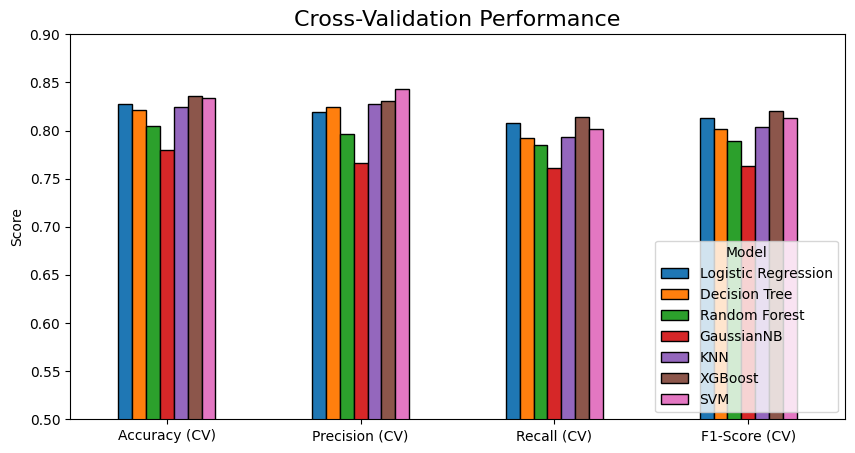

In [41]:
def plot_metrics(df, title):
    metric_cols = [col for col in df.columns if col not in ["Model", "Best Params", "Training Time (s)"]]
    
    df.set_index("Model")[metric_cols].T.plot(
        kind="bar", figsize=(10,5), edgecolor="black"
    )
    
    plt.title(title, fontsize=16)
    plt.ylabel("Score")
    plt.ylim(0.5, 0.9)    
    plt.xticks(rotation=0)  
    plt.legend(title="Model", loc="lower right")
    plt.show()

# Plot CV results
plot_metrics(cv_df, "Cross-Validation Performance")


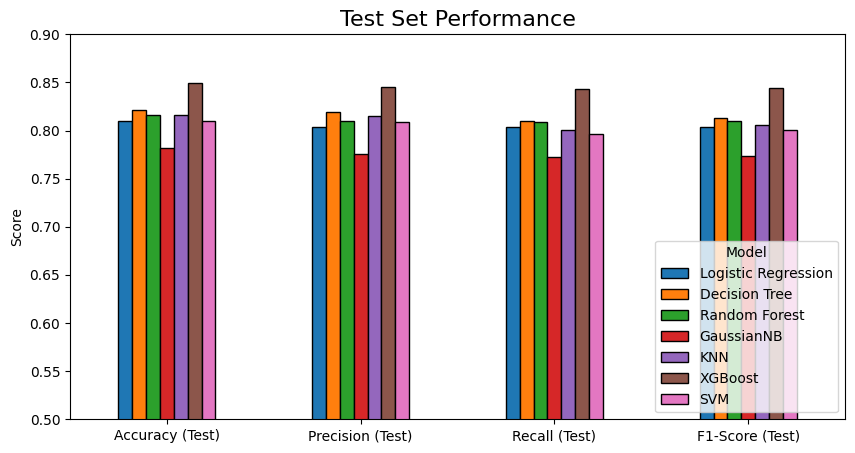

In [42]:
plot_metrics(test_df, "Test Set Performance")

## Final Results Comparison
We compare the performance of different models and identify the best-performing algorithm for the Titanic dataset. So, the best model is Xgboost with accuracy of 85 almost.

Prediciting the given test dataset and submitting the predicition in given format which has id and survived column

In [43]:
cv_df.loc[5]['Best Params']

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 1.0}

In [44]:
best_model = XGBClassifier(colsample_bytree=1,learning_rate=0.2,n_estimators=50,max_depth=3,subsample=0.7)
best_model.fit(x_train,y_train)
y_predicted = best_model.predict(test)
submission_df  = pd.DataFrame({
    'PassengerId' : ids,
    'Survived' : y_predicted
})
submission_df.to_csv('submission.csv',index=False)